# Libraries, Headers and Stuff

In [1]:
CACHED = True
CONTINUE = False

N_STATES = 64
N_EPOCHS = 50
BATCH_SIZE = 32

MAX_VOCAB_SIZE = -1
#MAX_SEQUENCE_SIZE = 100000
MAX_SEQUENCE_SIZE = -1

TEST_RATIO = .1

In [2]:
import numpy as np
import keras

Using TensorFlow backend.


In [3]:
%load_ext rpy2.ipython

In [4]:
import random
random.seed(55555)

In [5]:
import sys
sys.path.append('../src')

# Creates dataset

In [6]:
import nltk

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', unicode(input_str, 'latin-1'))
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def get_corpus(path, model_type = 'char'):
    if model_type == 'word':
        text = remove_accents(open(path).read()).lower()
    else:
        text = open(path).read().lower()
    
    chars = set(text)

    if model_type == 'word':
        #dataset = text.split()
        dataset = re.findall(r'\S+|\n',text)
        dataset = filter(lambda w: not w in [' '], dataset)
    elif model_type == 'char':
        dataset = list(text)
    else:
        dataset = list(text.encode("hex"))
        
    freq_dist = nltk.FreqDist(dataset)
    if MAX_VOCAB_SIZE > -1:
        out = filter(lambda w: not w in freq_dist.keys()[max_vocab_size:], dataset)
    else:
        out = dataset
    
    return out

raw_data = get_corpus('linux_kernel/corpus/linux_input.txt')

print 'Number of charaters', len(raw_data)
print 'Number of charaters', len(set(raw_data))

Number of charaters 6206996
Number of charaters 75


In [7]:
import utils.preprocess as pre

# Generates data
full_size = len(raw_data)
train_size = int((1-TEST_RATIO) * full_size)

train_sequence = raw_data[:train_size]
test_sequence = raw_data[train_size:]

raw_train_sequence, raw_test_sequence, char2int, int2char = pre.encode_split(train_sequence, test_sequence)

# If necessary, truncates:
if MAX_SEQUENCE_SIZE > 0:
    train_size = int(MAX_SEQUENCE_SIZE * (1-TEST_RATIO))
    test_size = int(MAX_SEQUENCE_SIZE * TEST_RATIO)
    raw_train_sequence = raw_train_sequence[:train_size]
    raw_test_sequence  = raw_test_sequence[:test_size]

print 'Training smybols:', len(raw_train_sequence)
print 'Testing smybols:', len(raw_test_sequence)
print 'Size vocabulay:', len(char2int)

Encoding
Total vocabulary size:  75
Training smybols: 5586296
Testing smybols: 620700
Size vocabulay: 75


In [8]:
import numpy as np
import utils.preprocess as pre
reload(pre)

# Preprocesses training
# SPLITS
X_train_raw = raw_train_sequence[:-1]
y_train_raw = raw_train_sequence[1:]
# ENCODES
X_train = pre.one_hot_encode_seq(X_train_raw, n_chars=len(int2char))
y_train = pre.one_hot_encode_seq(y_train_raw, n_chars=len(int2char))
# SHUFFLES
train_indices = pre.shuffle_indices(len(X_train_raw), BATCH_SIZE)
y_train = y_train[train_indices]
# EXPANDS
X_train = X_train[train_indices,np.newaxis,:]

# Preprocesses testing
# SPLITS
X_test_raw = raw_test_sequence[:-1]
y_test_raw = raw_test_sequence[1:]
# ENCODES
X_test = pre.one_hot_encode_seq(X_test_raw, n_chars=len(int2char))
y_test = pre.one_hot_encode_seq(y_test_raw, n_chars=len(int2char))
# SHUFFLES
test_indices = pre.shuffle_indices(len(X_test_raw), BATCH_SIZE)
X_test = X_test[test_indices, np.newaxis,:]
y_test = y_test[test_indices]

print "Training data:"
print "X:", X_train.shape
print "y:", y_train.shape

print "Test data:"
print "X:", X_test.shape
print "y:", y_test.shape

# Recovers the original training data
X_test_sequence = test_sequence[:X_test.shape[0]]
y_test_sequence = test_sequence[1:X_test.shape[0]+1]
print 'Test sequences:', X_test_sequence[:5], y_test_sequence[:5]
print 'length:', len(X_test_sequence), len(y_test_sequence)

Training data:
X: (5586272, 1, 75)
y: (5586272, 75)
Test data:
X: (620672, 1, 75)
y: (620672, 75)
Test sequences: ['_', 'k', 't', 'h', 'r'] ['k', 't', 'h', 'r', 'e']
length: 620672 620672


In [9]:
print(''.join(X_test_sequence)[:500])

_kthread))
		return;
	if (access_once(rdp_leader->nocb_leader_sleep) || force) {
		/* prior smp_mb__after_atomic() orders against prior enqueue. */
		access_once(rdp_leader->nocb_leader_sleep) = false;
		wake_up(&rdp_leader->nocb_wq);
	}
}

/*
 * does the specified cpu need an rcu callback for the specified flavor
 * of rcu_barrier()?
 */
static bool rcu_nocb_cpu_needs_barrier(struct rcu_state *rsp, int cpu)
{
	struct rcu_data *rdp = per_cpu_ptr(rsp->rda, cpu);
	unsigned long ret;
#ifdef config_


# Creates the model

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM,SimpleRNN
from keras.layers import Lambda
from keras import regularizers

from controllers.mylstm import MYLSTM

in_dim = X_train.shape[1:]
out_dim = y_train.shape[1]

model = Sequential()
model.add(MYLSTM(N_STATES, stateful=True,
                            batch_size=BATCH_SIZE,
                            input_shape=in_dim,
                            dropout=.3))
model.add(Dense(out_dim, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [11]:
from keras.models import load_model
from controllers.mylstm import MYLSTM
if not CACHED:
    if CONTINUE:
        model = load_model('../models/kernel_init', custom_objects={'MYLSTM' :MYLSTM})
    for i in range(N_EPOCHS):
        model.reset_states()
        history = model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=1,
                            verbose=1,
                            shuffle=False)
        model.save('../models/kernel_init' + str(i))
else:
    model = load_model('../models/kernel_init_fri', custom_objects={'MYLSTM' :MYLSTM})

In [12]:
model.reset_states()
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

620640/620672 [============================>.] - ETA: 0s('Test score:', 2.0825656512996096)
('Test accuracy:', 0.43408112497422147)


In [29]:
# Generate samples
import generator as gen

print gen.complete_sentence_stateful('if ', model, 500, char2int, int2char,BATCH_SIZE)
print '*****'
print gen.complete_sentence_stateful('else', model, 500, char2int, int2char, BATCH_SIZE)

Dimensions of sentence after encoding: (32, 3, 75)
Dimensions of sentence after generation: (32, 504, 75)
if or (pap = snoct rope_secisnterem = dimakem;

	rentimer flag_cpu) {
		line of out, uuad *ons);
}

/**
are = &fser waituger to jocuuch>\n",
	*
			 * and fixers;

	i* "ending scheduliting in the thread(return refislock(&fo->time, sser * mut(cds + _q_app, &a0];

	such_ing->get be errbary natch accovgs filer->ret)
	 **
 */
	__static void ftrace.
	 * return static raw_rcu_nable parss->ting_in struct task)
{

/* just sponn   statecalwask = rt_slocks lice of (et_irqsy), 3 buffer);

	return;

	/*
	ussm'tk
*****
Dimensions of sentence after encoding: (32, 4, 75)
Dimensions of sentence after generation: (32, 505, 75)
else a[i		return frreelcev;
 * keim(and hk;

/*

	 * @piv->su32);

	/* return 0;
#endif(in (plagible, locks.
		__ops and fuge not with be out isling all(task(void *rp->count buffep t;

	/*
	.ibj.
		goto kist_i->nobs al.cby sunp_to the (users an ? i30)) {
	call;
}

static int s

# Extracts features

In [14]:
import features as feat
reload(feat)

alphabet = feat.alphabet()
brackets = feat.is_enclosed_bin('(', ')')
curly_brackets = feat.is_enclosed_bin('{', '}')
linepos = feat.line_char_pos()
features = [linepos, alphabet, brackets, curly_brackets]

In [15]:
reload(feat)

feature_frame_x = feat.FeatureFrame(features, X_test_sequence)
feature_frame_x.extract()

feature_frame_y = feat.FeatureFrame(features, y_test_sequence)
feature_frame_y.extract()

print'Features for test sequence:'
print feature_frame_x.names
print feature_frame_x.values[:25,:]

print 'Features for test sequence labels:'
print feature_frame_y.names
print feature_frame_y.values[:25,:]

Generating feature scores
Running feature 0 out of 4
Added features ['line_pos']
Running feature 1 out of 4
Added features ['char_\t', 'char_\n', 'char_\xa9', 'char_!', 'char_ ', '...']
Running feature 2 out of 4
Added features ['dep_()_1', 'dep_()_2', 'dep_()_3', 'dep_()_4']
Running feature 3 out of 4
Added features ['dep_{}_1', 'dep_{}_2', 'dep_{}_3', 'dep_{}_4', 'dep_{}_5', '...']
Tidying...
Computed feature matrix, with shape: (620672, 82)
Snippet of the features
t cpu;

	for_each_possible_cpu(cpu)
		context_trac
['line_pos', 'char_\t', 'char_\n', 'char_\xa9', 'char_!', 'char_ ', 'char_#', 'char_"', 'char_%', 'char_$', "char_'", 'char_&', 'char_)', 'char_(', 'char_+', 'char_*', 'char_-', 'char_,', 'char_/', 'char_.', 'char_1', 'char_0', 'char_3', 'char_2', 'char_5', 'char_4', 'char_7', 'char_6', 'char_9', 'char_8', 'char_;', 'char_:', 'char_=', 'char_<', 'char_?', 'char_>', 'char_@', 'char_[', 'char_]', 'char_\\', 'char__', 'char_^', 'char_a', 'char_`', 'char_c', 'char_b', 'char_e'

# Extracts hidden states

In [16]:
import extractor
reload(extractor)

ex=extractor.Extractor(model)
states, nn_config = ex.run_for_layer('MYLSTM', X_test, batch_size=BATCH_SIZE, unshuffle=True)

print 'states shape:', states.shape
print 'config:',nn_config
# Checks
for i in range(states.shape[0] - 25,states.shape[0]):
    print X_test_sequence[i], '----', states[i,...]

Gets the activations for the hidden states
Reshapes
Done
states shape: (620672, 64)
config: {'input_size': 1, 'states_struct': [('MYLSTM', 1, 64)]}
e ---- [-0.76159418  0.76159418 -0.51076615 -0.08577678  0.         -0.43900529
  0.29620603  0.00962068  0.3355394   0.         -0.1617385   0.
  0.55405217 -0.30089575  0.2276741  -0.19688611  0.         -0.4917661   0.
  0.          0.         -0.70065361 -0.65519583 -0.33591202 -0.66760784
  0.24233986 -0.53467578 -0.27678925  0.         -0.68983358  0.76159418
  0.          0.1784393   0.89188838 -0.35722679  0.          0.          0.
  0.18854116  0.1031636   0.         -0.7609185   0.          0.
 -0.56793535  0.          0.30359021  0.         -0.34988624  0.          0.
 -0.96402758  0.76149344 -0.09589536 -0.59063989  0.          0.10871989
  0.62865067  0.          0.          0.52031124  0.26553571 -0.51578087
  0.        ]
_ ---- [-0.76159418  0.         -0.5438115   0.          0.          0.          0.
  0.          0.     

In [23]:
feat_names, feat_mat = feature_frame_x.data
feat_names

['line_pos',
 'char_\t',
 'char_\n',
 'char_\xa9',
 'char_!',
 'char_ ',
 'char_#',
 'char_"',
 'char_%',
 'char_$',
 "char_'",
 'char_&',
 'char_)',
 'char_(',
 'char_+',
 'char_*',
 'char_-',
 'char_,',
 'char_/',
 'char_.',
 'char_1',
 'char_0',
 'char_3',
 'char_2',
 'char_5',
 'char_4',
 'char_7',
 'char_6',
 'char_9',
 'char_8',
 'char_;',
 'char_:',
 'char_=',
 'char_<',
 'char_?',
 'char_>',
 'char_@',
 'char_[',
 'char_]',
 'char_\\',
 'char__',
 'char_^',
 'char_a',
 'char_`',
 'char_c',
 'char_b',
 'char_e',
 'char_d',
 'char_g',
 'char_f',
 'char_i',
 'char_h',
 'char_k',
 'char_j',
 'char_m',
 'char_l',
 'char_o',
 'char_n',
 'char_q',
 'char_p',
 'char_s',
 'char_r',
 'char_u',
 'char_t',
 'char_w',
 'char_v',
 'char_y',
 'char_x',
 'char_{',
 'char_z',
 'char_}',
 'char_|',
 'char_~',
 'dep_()_1',
 'dep_()_2',
 'dep_()_3',
 'dep_()_4',
 'dep_{}_1',
 'dep_{}_2',
 'dep_{}_3',
 'dep_{}_4',
 'dep_{}_5']

In [18]:
%%R -i feat_names,feat_mat,states,X_test_sequence

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names

to_plot <- filter(to_plot, Series %in%states_col_names | is_a_feature)
MAX_TIME <- 150 
to_plot <- filter(to_plot, time <= MAX_TIME)

labels <- X_test_sequence[1:MAX_TIME]
print(labels)

p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")

p

ggsave('~/Desktop/activations_linux.pdf', p, width=20, height=30)

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Use suppressPackageStartupMessages() to eliminate package startup
messages.

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attachement du package : ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


  [1] "_"  "k"  "t"  "h"  "r"  "e"  "a"  "d"  ")"  ")"  "\n" "\t" "\t" "r"  "e" 
 [16] "t"  "u"  "r"  "n"  ";"  "\n" "\t" "i"  "f"  " "  "("  "a"  "c"  "c"  "e" 
 [31] "s"  "s"  "_"  "o"  "n"  "c"  "e"  "("  "r"  "d"  "p"  "_"  "l"  "e"  "a" 
 [46] "d"  "e"  "r"  "-"  ">"  "n"  "o"  "c"  "b"  "_"  "l"  "e"  "a"  "d"  "e" 
 [61] "r"  "_"  "s"  "l"  "e"  "e"  "p"  ")"  " "  "|"  "|"  " "  "f"  "o"  "r" 
 [76] "c"  "e"  ")"  " "  "{"  "\n" "\t" "\t" "/"  "*"  " "  "p"  "r"  "i"  "o" 
 [91] "r"  " "  "s"  "m"  "p"  "_"  "m"  "b"  "_"  "_"  "a"  "f"  "t"  "e"  "r" 
[106] "_"  "a"  "t"  "o"  "m"  "i"  "c"  "("  ")"  " "  "o"  "r"  "d"  "e"  "r" 
[121] "s"  " "  "a"  "g"  "a"  "i"  "n"  "s"  "t"  " "  "p"  "r"  "i"  "o"  "r" 
[136] " "  "e"  "n"  "q"  "u"  "e"  "u"  "e"  "."  " "  "*"  "/"  "\n" "\t" "\t"


# Correlation based attribution

In [19]:
import scores
reload(scores)
import inspector as ip
reload(ip)
print 'Snippet test sequence:', X_test_sequence[:100]
print 'Size', len(X_test_sequence)

insp = ip.Inspector(nn_config)

params = {(0,0):(scores.Correlation(), 0, 0)}
mi_scores,names = insp.inspect(states, feature_frame_x, params)

Snippet test sequence: ['_', 'k', 't', 'h', 'r', 'e', 'a', 'd', ')', ')', '\n', '\t', '\t', 'r', 'e', 't', 'u', 'r', 'n', ';', '\n', '\t', 'i', 'f', ' ', '(', 'a', 'c', 'c', 'e', 's', 's', '_', 'o', 'n', 'c', 'e', '(', 'r', 'd', 'p', '_', 'l', 'e', 'a', 'd', 'e', 'r', '-', '>', 'n', 'o', 'c', 'b', '_', 'l', 'e', 'a', 'd', 'e', 'r', '_', 's', 'l', 'e', 'e', 'p', ')', ' ', '|', '|', ' ', 'f', 'o', 'r', 'c', 'e', ')', ' ', '{', '\n', '\t', '\t', '/', '*', ' ', 'p', 'r', 'i', 'o', 'r', ' ', 's', 'm', 'p', '_', 'm', 'b', '_', '_']
Size 620672
Computing attribution scores
Feture matrix dimensions: (620672, 82)
States dimensions: (620672, 64)
Computing score for feature 0: line_pos
Layer 0
Cell 0
Scoring neurons 0 to 63
Computing score for feature 1: char_	
Layer 0
Cell 0
Scoring neurons 0 to 63
Computing score for feature 2: char_

Layer 0
Cell 0
Scoring neurons 0 to 63
Computing score for feature 3: char_�
Layer 0
Cell 0
Scoring neurons 0 to 63
Computing score for feature 4: char_!
Layer 0


In [20]:
insp.states_struct

[('MYLSTM', 1, 64)]

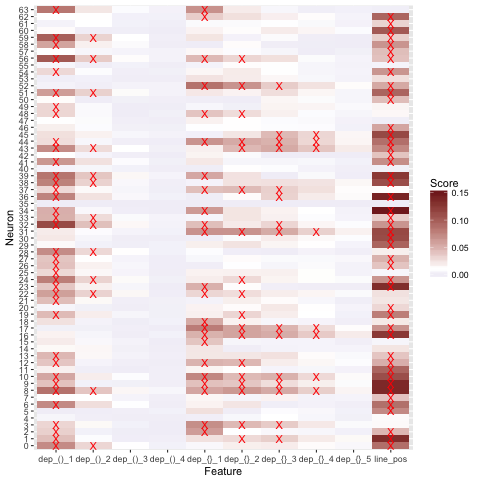

In [27]:
%%R -i mi_scores,names,N_STATES

library(ggplot2)
library(scales) 
library(dplyr)
library(tidyr)

data <- as.data.frame(mi_scores)
names(data) <- names
data[['Neuron']] <- factor(0:(N_STATES-1),
                           levels = 0:(N_STATES-1),
                           labels = as.character(0:(N_STATES-1)))

to_plot <- data #[(nrow(data)-N_STATES+1):nrow(data),]

to_plot <- gather(to_plot, key='Feature', value='Score', -Neuron)

to_plot <- to_plot %>% filter(Feature %in% c('line_pos', 'dep_()_1',
 'dep_()_2',
 'dep_()_3',
 'dep_()_4',
 'dep_{}_1',
 'dep_{}_2',
 'dep_{}_3',
 'dep_{}_4',
 'dep_{}_5'))

thres <- quantile(to_plot$Score, .75)
to_plot$scorebin <- ifelse(to_plot$Score > thres, 'X', '')

p <- ggplot(to_plot, aes(x=Feature, y=Neuron, fill=Score, label=scorebin)) + 
                geom_bin2d(aes='identity') +
                geom_text(color='red') +
                scale_fill_gradient2(midpoint=median(to_plot$Score),
                                    low = muted("blue"), mid = "white",high = muted("red"),
                                    limits=c(0,NA))

ggsave('~/Desktop/correlation_map_linux.pdf', p, width=20, height=30)
p

# Does the Unit Test

In [22]:
import scores
import inspector as ip

# With random neurons
NEURONS = [5,9,12,14,17,20,27,30]
BASELINE_NEURONS = [i for i in range(N_STATES) if i not in NEURONS]

mapping = {}
for featname in names:
    mapping[featname] = (BASELINE_NEURONS, scores.LogRegF1(), 0) 

insp = ip.Inspector(nn_config)
out = insp.test(states, feature_frame_x, mapping)
out

Computing scores for char_o
Computing scores for char_n
Computing scores for char_m
Computing scores for char_l
Computing scores for char_k
Computing scores for char_j
Computing scores for char_i
Computing scores for char_h
Computing scores for char_g
Computing scores for char_f
Computing scores for char_e
Computing scores for char_d


KeyboardInterrupt: 

In [ ]:
# With the correct neuronss 
mapping = {}
for featname in names:
    mapping[featname] = (NEURONS, scores.LogRegF1(), 0) 

insp = ip.Inspector(nn_config)
out = insp.test(states, feature_frame_x, mapping)
out

# Kevinizes

In [ ]:
import controllers.control as cont
reload(cont)
import verify as ver
reload(ver)

# NEURONS = [5,9,12,14,17,20,27,30]
# BASELINE_NEURONS = [i for i in range(N_STATES) if i not in NEURONS]

v_scores = ver.verify(model, 0, NEURONS, BASELINE_NEURONS, 
                      feature_frame_y, X_test, y_test, BATCH_SIZE)

In [ ]:
import verify as ver
reload(ver)
ver.test_diff(v_scores)